In [1]:
from keras.utils import np_utils
import numpy as np
from glob import glob
import cv2
import matplotlib.pyplot as plt
import os
%matplotlib inline

Using TensorFlow backend.


In [2]:
import tensorflow as tf
# Checking GPU
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


The data is divided into folders were each folder corresponds to a patient.

In [3]:
# Path to data
path = "./Data/IDC_regular_ps50_idx5"
# Identify data folders
folders = [folder for folder in os.listdir(path)]

print("Number of patients: %d" %len(folders))

Number of patients: 279


Let's look to an image and its shape:

Image shape: (50, 50, 3)


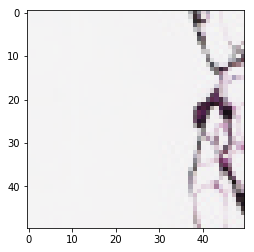

In [4]:
img = cv2.imread(path + '/' + '10264' + '/' + '0' + '/' + '10264_idx5_x51_y1651_class0.png')
# Convert to RGB
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)
print("Image shape: {}".format(img.shape))

Function to load the images:

In [5]:
def path_to_tensor(img_path):
    # load images
    img = cv2.imread(img_path)
    # Convert to RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if img.shape == (50, 50, 3):
        # convert 3D tensor to 4D tensor with shape (1, 50, 50, 3) and return 4D tensor
        #return np.expand_dims(img, axis=0)
        return img.astype(np.float32) / 255
        #return img.reshape([50,50,3])

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)


Each patient's folder contains two folders: a folder with non cancer images and a folder with cancerous tissue images.

In [6]:
# Healthy tissue is on folder 0 and cancerous tissue in folder 1
folder_label = ['0', '1']
images = []
labels = []

for folder in folders:
    # Read from folder 0 and create corresponding label array
    path_0 = path + '/' + folder + '/' + folder_label[0]
    images_0 = [path_to_tensor(path_0 + '/' + img_path) for img_path in os.listdir(path_0) \
               if path_to_tensor(path_0 + '/' + img_path) is not None]
    labels_0 = np.zeros(len(images_0), dtype=np.int8)
    images.extend(images_0)
    labels.extend(labels_0)
    # Read from folder 1 and create corresponding label array
    path_1 = path + '/' + folder + '/' + folder_label[1]
    images_1 = [path_to_tensor(path_1 + '/' + img_path) for img_path in os.listdir(path_1) \
               if path_to_tensor(path_1 + '/' + img_path) is not None]
    labels_1 = np.ones(len(images_1), dtype=np.int8)
    images.extend(images_1)
    labels.extend(labels_1)    

Number of images: 275222
Number of labels: 275222


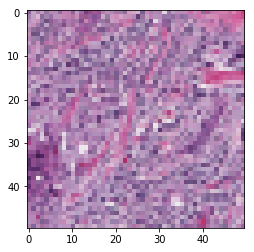

In [8]:
images = np.array(images)
labels = np.array(labels)
print("Number of images: {}".format(len(images)))
print("Number of labels: {}".format(len(labels)))

_ = plt.imshow(images[0])

In [9]:
print("Number of 1 labels: {}".format(np.sum(labels)))
print("Number of 0 labels: {}".format(len(labels) - np.sum(labels)))

Number of 1 labels: 78768
Number of 0 labels: 196454


Let's divide the patients bewteen a training set, validation set. 90% of the patients are held for training, 10% are assigned for testing and the remaining are kept for validation. The training set is further divided to get also a test set to develop the model

In [10]:
from sklearn.model_selection import train_test_split

seed = 42
np.random.seed(seed)
idx_train, idx_val = train_test_split(np.arange(labels.shape[0]), test_size=0.1, \
                                      random_state=seed, shuffle=True, stratify=labels)

Define model architecture:

In [17]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential

model = Sequential()

### Architecture
# Layer 1 : input layer
model.add(Conv2D(filters=32, kernel_size=3, padding='same', \
                activation='relu', input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.2))
# Layer 2
model.add(Conv2D(filters=64, kernel_size=3, padding='same', \
                activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.2))
# Layer 3
model.add(Conv2D(filters=128, kernel_size=3, padding='same', \
                activation='relu'))
model.add(MaxPooling2D(pool_size=3))
#model.add(GlobalAveragePooling2D('channels_last'))
model.add(Flatten())
# Layer 4
model.add(Dense(64, activation='relu'))
# Output layer
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 5, 5, 128)         73856     
__________

Compile model:

In [18]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [19]:
from keras.callbacks import ModelCheckpoint, EarlyStopping  

epochs = 100
batch_size = 512

stopping_condition = EarlyStopping(patience=6)
checkpointer = ModelCheckpoint(filepath='./saved_models/weights.best.CNN_arch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(images[idx_train], labels[idx_train], \
          validation_split=0.1, \
          epochs=epochs, batch_size=batch_size, class_weight={0:1, 1:2.5},\
          callbacks=[checkpointer, stopping_condition], verbose=1)

Train on 222929 samples, validate on 24770 samples
Epoch 1/100
222929/222929 [==============================] - 15s 68us/step - loss: 0.7019 - acc: 0.7809 - val_loss: 0.6834 - val_acc: 0.7430

Epoch 00001: val_loss improved from inf to 0.68341, saving model to ./saved_models/weights.best.CNN_arch.hdf5
Epoch 2/100
222929/222929 [==============================] - 15s 66us/step - loss: 0.6267 - acc: 0.8064 - val_loss: 0.7020 - val_acc: 0.7073

Epoch 00002: val_loss did not improve from 0.68341
Epoch 3/100
222929/222929 [==============================] - 15s 69us/step - loss: 0.5933 - acc: 0.8184 - val_loss: 0.5818 - val_acc: 0.8254

Epoch 00003: val_loss improved from 0.68341 to 0.58180, saving model to ./saved_models/weights.best.CNN_arch.hdf5
Epoch 4/100
222929/222929 [==============================] - 15s 68us/step - loss: 0.5798 - acc: 0.8240 - val_loss: 0.5647 - val_acc: 0.8405

Epoch 00004: val_loss improved from 0.58180 to 0.56473, saving model to ./saved_models/weights.best.CNN_ar

Load model with best validation loss:

In [90]:
model.load_weights('./saved_models/weights.best.CNN_arch.hdf5')

Test model in validation set:

In [91]:
# get predictions for each image in test set
predictions = [np.int(np.round(model.predict(np.expand_dims(image, axis=0)))) \
               for image in images[idx_val]]

In [92]:
# report test accuracy
test_accuracy = np.sum(np.array(predictions)==labels[idx_val])/len(predictions)
print('Test accuracy: %.4f%%' %(100*test_accuracy))

Test accuracy: 84.8418%


Calculate F1 score, confusion matrix and ROC curve.

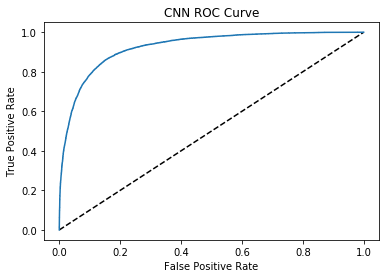

Precision for 0 and 1: 94.00% and 68.64%
Recall for 0 and 1: 84.14% and 86.59%
F1 score for 0 and 1: 88.79% and 76.58%
Confusion matrix:
 [[16530  3116]
 [ 1056  6821]]


In [93]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve

y_test = labels[idx_val]
y_pred = np.array(predictions)

confusion = confusion_matrix(y_test, y_pred)

precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, beta=1)

y_pred_prob = [np.float32(model.predict(np.expand_dims(image, axis=0))) \
               for image in images[idx_val]]
y_pred_prob = np.array(y_pred_prob).reshape(-1)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='CNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN ROC Curve')
plt.show()

print("Precision for 0 and 1: {:.2f}% and {:.2f}%".format(precision[0]*100, precision[1]*100))
print("Recall for 0 and 1: {:.2f}% and {:.2f}%".format(recall[0]*100, recall[1]*100))
print("F1 score for 0 and 1: {:.2f}% and {:.2f}%".format(f1_score[0]*100, f1_score[1]*100))
print("Confusion matrix:\n {}".format(confusion))

The classes are unbalanced, images with label 0 more than double images with label 1. So now let's train the model doing image augmentation.

In [23]:
from keras.preprocessing.image import ImageDataGenerator

# Create and configure image generator
data_gen_train = ImageDataGenerator(rotation_range=90.0, \
                                    width_shift_range=0.2, \
                                    height_shift_range=0.2, \
                                    horizontal_flip=True)

# Fit image generator to data
data_gen_train.fit(images[idx_train])

Given that augmented data is used, this time the method fit_generator is used. For fit_generator the validation data needs to be specified directly. It cannot represent a percentage of the training input. Then we divide the training data into a train and test sets.

In [24]:
idx_train_2, idx_test = train_test_split(np.arange(idx_train.shape[0]), test_size=0.1, \
                                      random_state=seed, shuffle=True, stratify=labels[idx_train])

Same architecture as before:

In [25]:
model = Sequential()

### Architecture
# Layer 1 : input layer
model.add(Conv2D(filters=32, kernel_size=3, padding='same', \
                activation='relu', input_shape=(50,50,3)))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.2))
# Layer 2
model.add(Conv2D(filters=64, kernel_size=3, padding='same', \
                activation='relu'))
model.add(MaxPooling2D(pool_size=3))
model.add(Dropout(0.2))
# Layer 3
model.add(Conv2D(filters=128, kernel_size=3, padding='same', \
                activation='relu'))
model.add(MaxPooling2D(pool_size=3))
#model.add(GlobalAveragePooling2D('channels_last'))
model.add(Flatten())
# Layer 4
model.add(Dense(64, activation='relu'))
# Output layer
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 50, 50, 32)        896       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 5, 5, 128)         73856     
__________

In [26]:
epochs = 100
batch_size = 256

stopping_condition = EarlyStopping(patience=6)
checkpointer = ModelCheckpoint(filepath='./saved_models/weights.best.CNN_arch_augmented.hdf5', 
                               verbose=1, save_best_only=True)

model.fit_generator(data_gen_train.flow(images[idx_train_2], labels[idx_train_2], \
                                   batch_size=batch_size), \
                    validation_data=(images[idx_test], labels[idx_test]), \
                    steps_per_epoch=len(idx_train_2)//batch_size, \
                    epochs=epochs, class_weight={0:1, 1:2.5},\
                    callbacks=[checkpointer, stopping_condition], verbose=1)

Epoch 1/100
870/870 [==============================] - 91s 104ms/step - loss: 0.6778 - acc: 0.7902 - val_loss: 0.6583 - val_acc: 0.6684

Epoch 00001: val_loss improved from inf to 0.65831, saving model to ./saved_models/weights.best.CNN_arch_augmented.hdf5
Epoch 2/100
870/870 [==============================] - 92s 105ms/step - loss: 0.6166 - acc: 0.8126 - val_loss: 0.6522 - val_acc: 0.6650

Epoch 00002: val_loss improved from 0.65831 to 0.65224, saving model to ./saved_models/weights.best.CNN_arch_augmented.hdf5
Epoch 3/100
870/870 [==============================] - 92s 105ms/step - loss: 0.5931 - acc: 0.8206 - val_loss: 0.5513 - val_acc: 0.7425

Epoch 00003: val_loss improved from 0.65224 to 0.55125, saving model to ./saved_models/weights.best.CNN_arch_augmented.hdf5
Epoch 4/100
870/870 [==============================] - 87s 101ms/step - loss: 0.5850 - acc: 0.8229 - val_loss: 0.4995 - val_acc: 0.7850

Epoch 00004: val_loss improved from 0.55125 to 0.49953, saving model to ./saved_mode

In [94]:
model.load_weights('./saved_models/weights.best.CNN_arch_augmented.hdf5')

In [95]:
# get predictions for each image in test set
predictions = [np.int(np.round(model.predict(np.expand_dims(image, axis=0)))) \
               for image in images[idx_val]]

In [96]:
# report test accuracy
test_accuracy = np.sum(np.array(predictions)==labels[idx_val])/len(predictions)
print('Test accuracy: %.4f%%' %(100*test_accuracy))

Test accuracy: 84.9362%


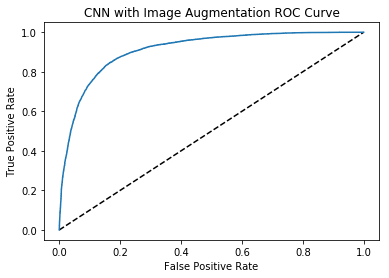

Precision for 0 and 1: 91.30% and 71.30%
Recall for 0 and 1: 87.21% and 79.27%
F1 score for 0 and 1: 89.21% and 75.08%
Confusion matrix:
 [[17133  2513]
 [ 1633  6244]]


In [97]:
y_test = labels[idx_val]
y_pred = np.array(predictions)

confusion = confusion_matrix(y_test, y_pred)

precision, recall, f1_score, support = precision_recall_fscore_support(y_test, y_pred, beta=1)

y_pred_prob = [np.float32(model.predict(np.expand_dims(image, axis=0))) \
               for image in images[idx_val]]
y_pred_prob = np.array(y_pred_prob).reshape(-1)

fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='CNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN with Image Augmentation ROC Curve')
plt.show()

print("Precision for 0 and 1: {:.2f}% and {:.2f}%".format(precision[0]*100, precision[1]*100))
print("Recall for 0 and 1: {:.2f}% and {:.2f}%".format(recall[0]*100, recall[1]*100))
print("F1 score for 0 and 1: {:.2f}% and {:.2f}%".format(f1_score[0]*100, f1_score[1]*100))
print("Confusion matrix:\n {}".format(confusion))